<a href="https://colab.research.google.com/github/DaliaAlzubi/Kidney_Tumor/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
import seaborn as sns; sns.set(color_codes=True)  # visualization tool
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os

import statistics
import collections
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
                    MultinomialNB, 
                    GaussianNB, 
                    BernoulliNB
                    )
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import (
                    SVC, 
                    NuSVC, 
                    LinearSVC
                    )
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing  import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from IPython.display import display 
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

import keras
from keras.models import Sequential , Model
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,MaxPooling2D,Input,Conv2DTranspose,Concatenate,BatchNormalization,UpSampling2D,AveragePooling2D,GlobalAveragePooling2D,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam , SGD
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

#from keras.utils import plot_model

from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import itertools


# Read Data 

In [ ]:
#!unzip sample_data/images_data.zip -d sample_data/

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
patient_info = drive.CreateFile({'id':"1dN1peOSeugjLLzzazh4yGoy_g1LBlzp7"})
patient_info.GetContentFile("patient_info.csv")
patient_info = pd.read_csv("patient_info.csv")

# Exploratory Data Analysis

In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Patient_ID                       120 non-null    object
 1   Patient_Num                      120 non-null    int64 
 2   Age                              120 non-null    int64 
 3   Gender                           120 non-null    object
 4   Test                             120 non-null    object
 5   Date                             120 non-null    int64 
 6   Taking_Contrast                  120 non-null    object
 7   Clinical_data                    120 non-null    object
 8   Symptoms                         120 non-null    object
 9   Diagnosing_test                  120 non-null    object
 10  Diagnosing_Right_Kidney          120 non-null    object
 11  Injure_range_Right_K_in_Details  120 non-null    object
 12  Segmentation_Right               120

In [ ]:
patient_info.head()

,Patient_ID,Patient_Num,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,Diagnosing_Right_Kidney,Injure_range_Right_K_in_Details,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K_in_Details,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class
0,KA00001301,1,33,Male,CT ABDOMEN PELVIS,2021,Yes,Not provided,Flank pain,Soft tissue mass lesion seen in the right adre...,Tissue adrenal,Tissue 2.3 x 1.7 cm adrenal,Undefined,Unremarkable,Unremarkable,Undefined,I,Tumor,Benign,Adenoma
1,KA00017864,2,56,Male,CT ABDOMEN PELVIS,2020,No,Not provided,Flank pain,"Mild bilateral hydronephrosis, kidney stone, l...",Tissue adrenal,Hyperdense lesion 1.5 cm adrenal,"Lower pole, Midportion",Hydronephrosis,"Hydronephrosis 1.6 cm, stone 1.3 cm",Lower calyceal,I,Tumor,Benign,Adenoma
2,KA00015810,3,50,Male,CT ABDOMEN PELVIS,2020,No,Kidney cyst and stone,Not provided,Adenpma adrenal gland,Tissue adrenal,"Adrenal gland , hydronephrosis 2.2cm",Lower calyceal,"Cyst, stone","Cyst 3.3 x 3.8cm, stone",Lower calyceal,I,Tumor,Benign,Adenoma
3,KA00017037,4,53,Male,CT ABDOMEN PELVIS,2021,Yes,Ewing sarcoma,Not provided,Stable bilateral adrenal lesions,"Tissue adrenal, hydronephrosis",Adrenal gland 2 x 1.7 cm,Upper pole,Tissue adrenal,"Adrenal gland 1.6 x 1 cm, cyst 1.3x 1.5 cm",Upper pole,I,Tumor,Benign,Adenoma
4,KA00103871,5,57,Male,CT ABDOMEN PELVIS,2020,No,Not provided,Flank pain,Few nonobstructive stones seen in both kidneys...,"Stone, cyst","Stone 6 mm, cyst, renal scars",Upper calyceal,"Tissue adrenal, stone","Stone, cyst 2.1 x 2.2 cm, Adrenal_g 1.4 x 1.6 cm","Midportion, Upper pole",I,Tumor,Benign,Adenoma


In [ ]:
patient_info.sample(5)

,Patient_ID,Patient_Num,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,Diagnosing_Right_Kidney,Injure_range_Right_K_in_Details,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K_in_Details,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class
40,KA00120802,41,78,Male,CT ABDOMEN PELVIS,2021,Yes,"Bulky prostate, Closed loop obstruction","Abdomen pain, Vomiting",large mass in left kidney extends beyond the p...,Healthy,Healthy,Undefined,Lesion,Lesion 8.0 x 6.0 x 9.0 cm,Renal pelvis,I,Tumor,Malignant,RCC
25,KA00228011,26,51,Female,CT ABDOMEN PELVIS,2020,Yes,Not provided,Abdomen pain,"Lesion liver 1 x 1 cm, lesion adrenal left, Ut...",Healthy,Healthy,Undefined,Tissue adrenal,Lesion adrenal 0.7 cm,Upper portion,I,Tumor,Benign,Adenoma
69,KA00196059,70,61,Female,CT ABDOMEN PELVIS,2020,Yes,Not provided,Abdomen pain,"Fatty liver 19 cm,",Cyst,Cyst,Upper pole,Cyst,Cyst,Upper pole,Null,Normal case with cyst,Null,Null
80,KA00118615,81,62,Female,CT ABDOMEN PELVIS,2020,No,Not provided,"Flank pain, Acute obstructive uropathy","Dystrophic calcifications in uterus, stone in ...","Cyst, stone","Fat, stone 2 cm, cyct 1.8 x 2.2 cm","Renal pelvis, Upper pole",Fat,Fat,Undefined,Null,Normal case with cyst,Null,Null
102,KA00128072,103,54,Female,CT ABDOMEN PELVIS,2020,No,"Diabetes, Hypertension","Hematuria, Flank pain",2 mm stone is in right VUJ,Hydronephrosis,Hydronephrosis 1.2 cm,Renal pelvis,Healthy,Healthy,Undefined,Null,Normal case,Null,Null


In [ ]:
patient_info['Tumor_Class'].value_counts()

Null                           60
Adenoma                        28
Secondary                      11
RCC                            10
Angiomyolipoma                  6
Angiomyolipoma                  2
Lipomas                         1
RCC                             1
Angiomyolipoma and Adenomas     1
Name: Tumor_Class, dtype: int64

In [ ]:
patient_info["Tumor_label"]= patient_info["Tumor_Type"]
cleanup_nums = {
    "Tumor_Class":{'RCC ':'RCC' , 'Angiomyolipoma ':'Angiomyolipoma' , "Null":"Uninfected" ,'Angiomyolipoma and Adenomas':'Angiomyolipoma' },
    "Tumor_Type":{"Null":"Uninfected"},
    "Tumor_label":{'Null':0  , "Benign":1 , 'Malignant':1 },
    "Situation" : {"Normal case" : "Normal case 'Healthy'"}
}
patient_info = patient_info.replace(cleanup_nums)

del cleanup_nums

In [ ]:
patient_info['Situation'].value_counts()

Tumor                    60
Normal case 'Healthy'    32
Normal case with cyst    28
Name: Situation, dtype: int64

In [ ]:
patient_info["Tumor_label"].value_counts()

1    60
0    60
Name: Tumor_label, dtype: int64

In [ ]:
bins = [30, 40,50,60,70,np.inf]
names = ['30-40', '40-50',"50-60",'60-70','80+']
patient_info['age_range'] = pd.cut(patient_info['Age'], bins, labels=names)


In [ ]:
del patient_info['Test']

Male      65
Female    55
Name: Gender, dtype: int64

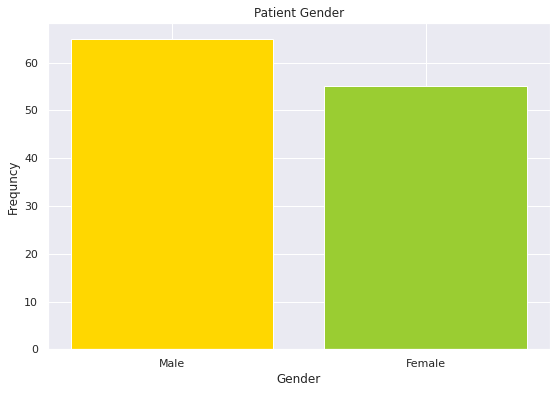

In [ ]:
gender_flg = patient_info['Gender'].value_counts()
display(gender_flg)
plt.figure(figsize = (9 , 6))
plt.bar(gender_flg.index , gender_flg , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Gender')
plt.ylabel('Frequncy')
plt.title('Patient Gender')
plt.show()
del gender_flg

Male      38
Female    22
Name: Gender, dtype: int64

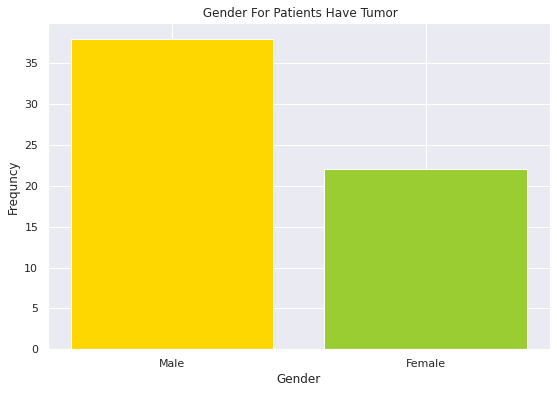

In [ ]:
gender_flg = patient_info [patient_info['Tumor_label'] != 0 ]['Gender'].value_counts()
display(gender_flg)
plt.figure(figsize = (9 , 6))
plt.bar(gender_flg.index , gender_flg , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Gender')
plt.ylabel('Frequncy')
plt.title(' Gender For Patients Have Tumor')
plt.show()


In [ ]:
patient_info [patient_info['Tumor_label'] != 0 ]['Age'].mean()

60.666666666666664

50-60    40
80+      27
60-70    26
40-50    15
30-40     8
Name: age_range, dtype: int64

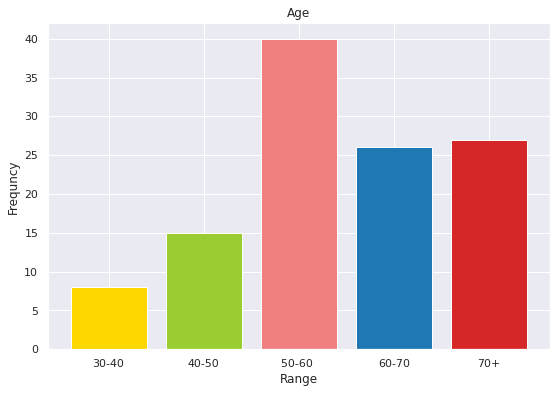

In [ ]:
age_range_flg = patient_info['age_range'].value_counts()
display(age_range_flg)
a_l = ['30-40','40-50','50-60 ','60-70','70+']
v_l = [8,15,40,26,27]
plt.figure(figsize = (9 , 6))
plt.bar(a_l , v_l , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Range')
plt.ylabel('Frequncy')
plt.title('Age')
plt.show()
del age_range_flg

50-60    19
80+      16
60-70    14
40-50     6
30-40     5
Name: age_range, dtype: int64

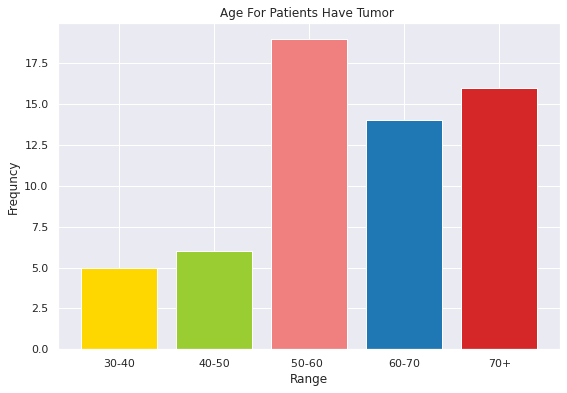

In [ ]:
age_range_flg =patient_info [patient_info['Tumor_label'] != 0 ]['age_range'].value_counts()
display(age_range_flg)
a_l = ['30-40','40-50','50-60 ','60-70','70+']
v_l = [5,6,19,14,16]
plt.figure(figsize = (9 , 6))
plt.bar(a_l , v_l , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Range')
plt.ylabel('Frequncy')
plt.title('Age For Patients Have Tumor ')
plt.show()
del age_range_flg

2020    83
2021    37
Name: Date, dtype: int64

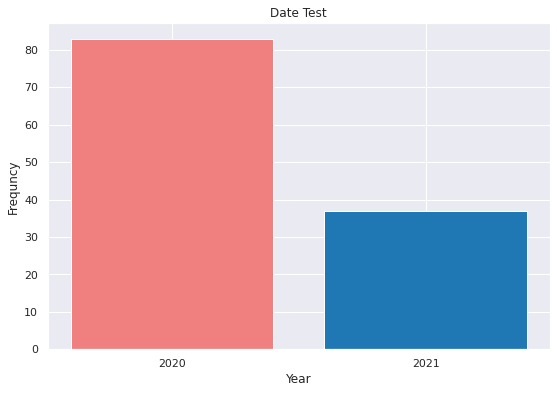

In [ ]:
labels = ['2020','2021']
Date_flg = patient_info['Date'].value_counts()
display(Date_flg)
plt.figure(figsize = (9 , 6))
plt.bar( labels , Date_flg , color=['lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Year')
plt.ylabel('Frequncy')
plt.title('Date Test')
plt.show()
del Date_flg
del labels

Yes    73
No     47
Name: Taking_Contrast, dtype: int64

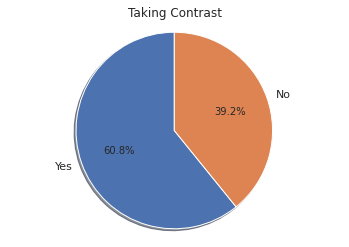

In [ ]:
Taking_Contrast_flg = patient_info['Taking_Contrast'].value_counts()
display(Taking_Contrast_flg)
fig1, ax1 = plt.subplots()
labels=['Yes', "No"]
plt.pie( Taking_Contrast_flg , labels=labels , autopct='%1.1f%%', shadow=True, startangle=90 )
ax1.axis('equal')
plt.title('Taking Contrast')
plt.show()
del Taking_Contrast_flg
del labels
del fig1
del ax1

Yes    38
No     22
Name: Taking_Contrast, dtype: int64

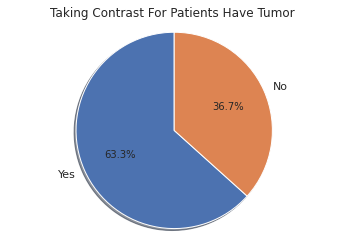

In [ ]:
Taking_Contrast_flg =  patient_info [patient_info['Tumor_label'] != 0 ]['Taking_Contrast'].value_counts()
display(Taking_Contrast_flg)
fig1, ax1 = plt.subplots()
labels=['Yes', "No"]
plt.pie( Taking_Contrast_flg , labels=labels , autopct='%1.1f%%', shadow=True, startangle=90 )
ax1.axis('equal')
plt.title('Taking Contrast For Patients Have Tumor ')
plt.show()
del Taking_Contrast_flg
del labels
del fig1
del ax1

Yes    35
No     25
Name: Taking_Contrast, dtype: int64

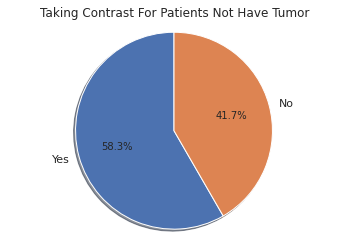

In [ ]:
Taking_Contrast_flg =  patient_info [patient_info['Tumor_label'] != 1 ]['Taking_Contrast'].value_counts()
display(Taking_Contrast_flg)
fig1, ax1 = plt.subplots()
labels=['Yes', "No"]
plt.pie( Taking_Contrast_flg , labels=labels , autopct='%1.1f%%', shadow=True, startangle=90 )
ax1.axis('equal')
plt.title('Taking Contrast For Patients Not Have Tumor')
plt.show()
del Taking_Contrast_flg
del labels
del fig1
del ax1

Uninfected    60
Benign        38
Malignant     22
Name: Tumor_Type, dtype: int64

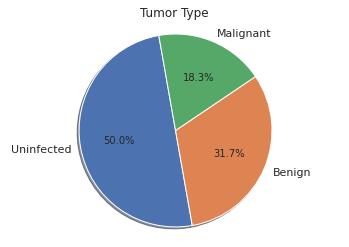

In [ ]:
Tumor_Type_flg = patient_info['Tumor_Type'].value_counts()
display(Tumor_Type_flg)
fig1, ax1 = plt.subplots()
labels=['Yes', "No"]
plt.pie( Tumor_Type_flg , labels= list (Tumor_Type_flg.index ) , autopct='%1.1f%%', shadow=True, startangle=100 )
ax1.axis('equal')
plt.title('Tumor Type')
plt.show()
del Tumor_Type_flg 
del labels
del fig1
del ax1

Uninfected        60
Adenoma           28
RCC               11
Secondary         11
Angiomyolipoma     9
Lipomas            1
Name: Tumor_Class, dtype: int64

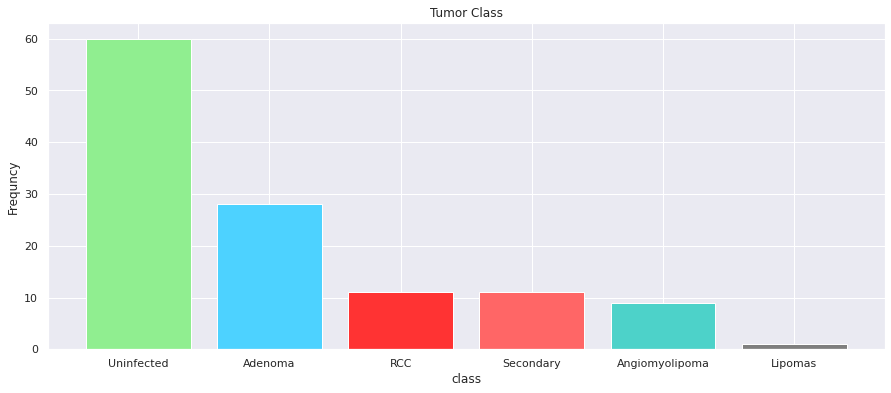

In [ ]:
Tumor_Class_flg = patient_info[patient_info['Tumor_Class']!="Null" ]
Tumor_Class_flg = Tumor_Class_flg['Tumor_Class'].value_counts()

display(Tumor_Class_flg)
plt.figure(figsize = (15 , 6))
plt.bar( Tumor_Class_flg.index , Tumor_Class_flg , color=['lightgreen','#4dd2ff','#ff3333', '#ff6666', '#4dd2c9','#7f7f7f'])
plt.xlabel('class')
plt.ylabel('Frequncy')
plt.title('Tumor Class')
plt.show()
del Tumor_Class_flg

In [ ]:
['Adenoma','Angiomyolipoma'] # حميد
['RCC','Secondary'] # خبيث 

['RCC', 'Secondary']

Undefined                                    57
Upper portion                                 9
Upper pole                                    8
Renal pelvis                                  7
Midportion                                    7
Midportion                                    4
Renal pelvis, Upper portion                   3
Left renal pelvis                             2
Lower pole                                    2
Midportion, Upper pole                        2
Lower calyceal                                2
Medial limb                                   1
Renal pelvis, Calyceal                        1
Midportion, Lower calyceal                    1
Lower pole, Upper portion                     1
Upper calyceal                                1
Lower portion, Lower calyceal                 1
Midportion and Lower portion                  1
Left-sided parapelvic                         1
Left renal pelvis, Lower calyceal             1
Upper and Middle portions               

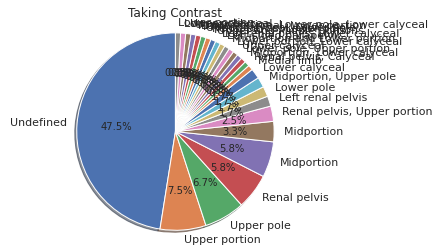

In [ ]:
Taking_Contrast_flg = patient_info['Segmentation_Left'].value_counts()
display(Taking_Contrast_flg)
fig1, ax1 = plt.subplots()
labels=['Yes', "No"]
plt.pie( Taking_Contrast_flg , labels=Taking_Contrast_flg.index , autopct='%1.1f%%', shadow=True, startangle=90 )
ax1.axis('equal')
plt.title('Taking Contrast')
plt.show()
del Taking_Contrast_flg
del labels
del fig1
del ax1

Not provided                              43
Flank pain                                28
Abdomen pain                              18
Abdominal pain                             6
Abdomen pain, Vomiting                     4
Flank pain                                 4
Hematuria, Flank pain                      3
Flank pain, Vomiting                       2
Constipation                               1
Acute obstructive uropathy                 1
Abdomen pain, Vomiting                     1
Bleeding per rectum                        1
Anemia, weight loss                        1
Abdomen pain                               1
Abdomenal pain                             1
Fever                                      1
Flank pain, Acute obstructive uropathy     1
Bilateral flank pain                       1
Abdominal pain                             1
Tiredness                                  1
Name: Symptoms, dtype: int64

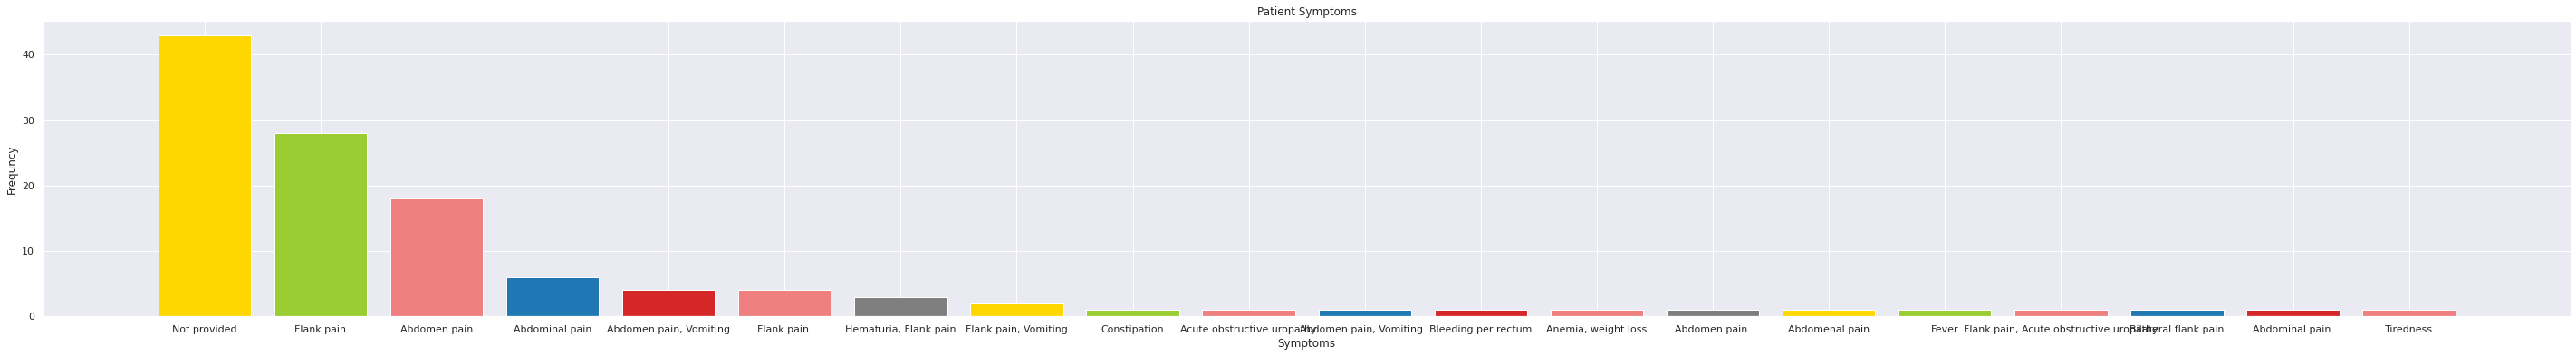

In [ ]:
Symptoms_flg = patient_info['Symptoms'].value_counts()
display(Symptoms_flg)
plt.figure(figsize = (50 , 6))
plt.bar(Symptoms_flg.index , Symptoms_flg , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Symptoms')
plt.ylabel('Frequncy')
plt.title('Patient Symptoms')
plt.show()
del Symptoms_flg

Healthy                           25
Cyst                              22
Lesion                             8
Hydronephrosis                     8
Tissue adrenal                     8
Stone                              6
Hydronephrosis                     4
Cyst                               4
Tissue adrenal, cyst               4
Tissue adrenal                     3
Unremarkable                       3
Cyst, stone                        3
Hydronephrosis, stone              2
Lesion                             2
Hydronephrosis, stone, cyst        2
Nephrectomy                        2
Stone, cyst                        2
Fat                                2
Tissue adrenal, hydronephrosis     1
Tissue adrenal, lesion             1
Nephrectomy                        1
Bulky, cyst                        1
Renal scars                        1
Ruptured cortical cyst             1
Nephrectomy, tissue adrenal        1
Unremarkable                       1
Stone                              1
L

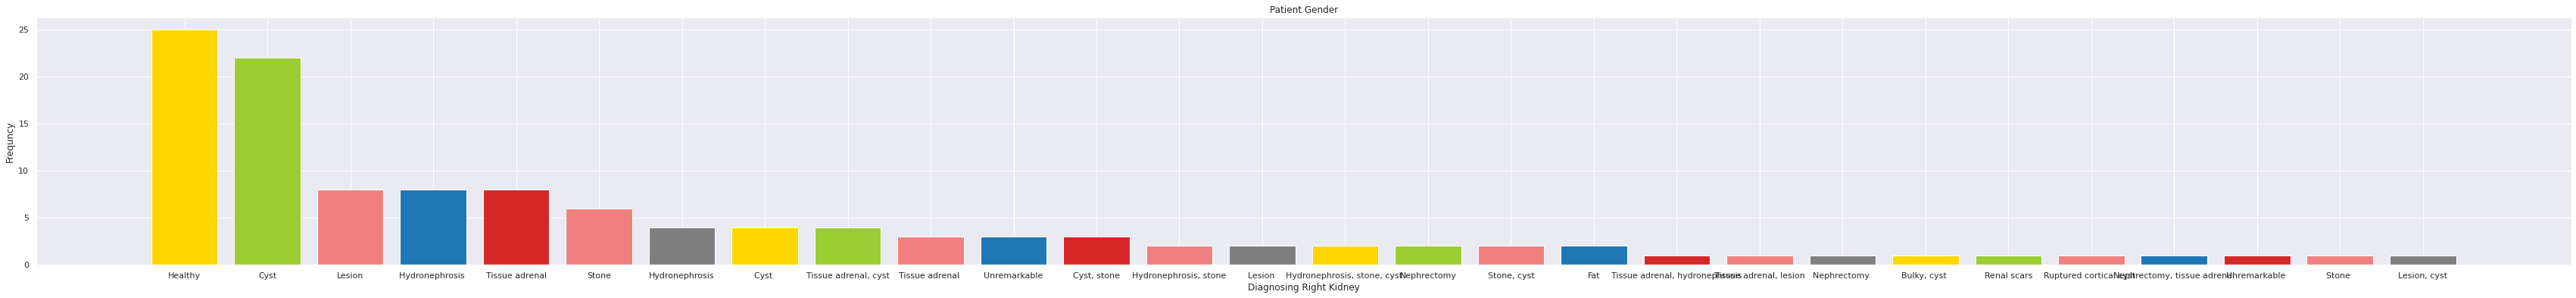

In [ ]:
Diagnosing_Right_Kidney_flg = patient_info['Diagnosing_Right_Kidney'].value_counts()
display(Diagnosing_Right_Kidney_flg)
plt.figure(figsize = (60 , 6))
plt.bar(Diagnosing_Right_Kidney_flg.index , Diagnosing_Right_Kidney_flg , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Diagnosing Right Kidney')
plt.ylabel('Frequncy')
plt.title('Patient Gender')
plt.show()
del Diagnosing_Right_Kidney_flg

In [ ]:
patient_info['Tumor_Type'].value_counts()

Uninfected    60
Benign        38
Malignant     22
Name: Tumor_Type, dtype: int64

# Create Tumor labels

1    60
0    60
Name: Tumor_label, dtype: int64

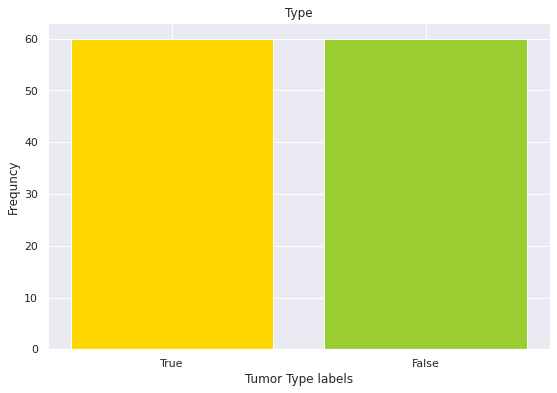

In [ ]:

Tumor_label_flg = patient_info['Tumor_label'].value_counts()
display(Tumor_label_flg)
label = ['True' , 'False']
plt.figure(figsize = (9 , 6))
plt.bar( label , Tumor_label_flg , color=['gold', 'yellowgreen', 'lightcoral','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Tumor Type labels')
plt.ylabel('Frequncy')
plt.title('Type')
plt.show()
del Tumor_label_flg
del label

In [ ]:
patient_info

,Patient_ID,Patient_Num,Age,Gender,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,Diagnosing_Right_Kidney,Injure_range_Right_K_in_Details,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K_in_Details,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Tumor_label,age_range
0,KA00001301,1,33,Male,2021,Yes,Not provided,Flank pain,Soft tissue mass lesion seen in the right adre...,Tissue adrenal,Tissue 2.3 x 1.7 cm adrenal,Undefined,Unremarkable,Unremarkable,Undefined,I,Tumor,Benign,Adenoma,1,30-40
1,KA00017864,2,56,Male,2020,No,Not provided,Flank pain,"Mild bilateral hydronephrosis, kidney stone, l...",Tissue adrenal,Hyperdense lesion 1.5 cm adrenal,"Lower pole, Midportion",Hydronephrosis,"Hydronephrosis 1.6 cm, stone 1.3 cm",Lower calyceal,I,Tumor,Benign,Adenoma,1,50-60
2,KA00015810,3,50,Male,2020,No,Kidney cyst and stone,Not provided,Adenpma adrenal gland,Tissue adrenal,"Adrenal gland , hydronephrosis 2.2cm",Lower calyceal,"Cyst, stone","Cyst 3.3 x 3.8cm, stone",Lower calyceal,I,Tumor,Benign,Adenoma,1,40-50
3,KA00017037,4,53,Male,2021,Yes,Ewing sarcoma,Not provided,Stable bilateral adrenal lesions,"Tissue adrenal, hydronephrosis",Adrenal gland 2 x 1.7 cm,Upper pole,Tissue adrenal,"Adrenal gland 1.6 x 1 cm, cyst 1.3x 1.5 cm",Upper pole,I,Tumor,Benign,Adenoma,1,50-60
4,KA00103871,5,57,Male,2020,No,Not provided,Flank pain,Few nonobstructive stones seen in both kidneys...,"Stone, cyst","Stone 6 mm, cyst, renal scars",Upper calyceal,"Tissue adrenal, stone","Stone, cyst 2.1 x 2.2 cm, Adrenal_g 1.4 x 1.6 cm","Midportion, Upper pole",I,Tumor,Benign,Adenoma,1,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,KA00119037,116,69,Female,2021,No,Bulky both adrenal glands,Flank pain,The right kidney appear bulky surrounding by f...,Fat,Fat,Undefined,Unremarkable,Unremarkable,Undefined,Null,Normal case 'Healthy',Uninfected,Uninfected,0,60-70
116,KA00003828,117,76,Male,2020,Yes,Not provided,"Abdomen pain, Vomiting","Bulky prostate gland, duodenitis, lesion liver",Healthy,Healthy,Undefined,Undefind,Undefind,Undefined,Null,Normal case 'Healthy',Uninfected,Uninfected,0,80+
117,KA00006120,118,57,Female,2021,No,Not provided,Abdomen pain,"Fatty infiltration of the liver, left sided a...",Unremarkable,Unremarkable,Undefined,Unremarkable,Unremarkable,Undefined,Null,Normal case 'Healthy',Uninfected,Uninfected,0,50-60
118,KA00007045,119,43,Female,2020,Yes,Not provided,"Anemia, weight loss",Rright sided adnexal cyst noted meaures about ...,Unremarkable,Unremarkable,Undefined,Unremarkable,Unremarkable,Undefined,Null,Normal case 'Healthy',Uninfected,Uninfected,0,40-50


In [ ]:
patient_info['Situation'].value_counts()

Tumor                    60
Normal case 'Healthy'    32
Normal case with cyst    28
Name: Situation, dtype: int64

In [ ]:
Situation_with_gender_male = patient_info [patient_info['Gender']== "Male"]
Situation_with_gender_male = Situation_with_gender_male.groupby(['Situation']) 
Situation_with_gender_male = Situation_with_gender_male['Patient_Num'].describe()
Situation_with_gender_male

,count,mean,std,min,25%,50%,75%,max
Situation,,,,,,,,
Normal case 'Healthy',15.0,106.600000,7.725653,89.0,101.5,108.0,112.50,117.0
Normal case with cyst,12.0,77.666667,8.876254,63.0,71.5,79.5,85.25,88.0
Tumor,38.0,29.394737,18.746588,1.0,11.5,29.0,44.75,60.0


In [ ]:
Situation_with_gender_female= patient_info [patient_info['Gender']== "Female"]
Situation_with_gender_female = Situation_with_gender_female.groupby(['Situation']) 
Situation_with_gender_female = Situation_with_gender_female['Patient_Num'].describe()
Situation_with_gender_female

,count,mean,std,min,25%,50%,75%,max
Situation,,,,,,,,
Normal case 'Healthy',17.0,102.647059,10.511548,90.0,94.00,100.0,111.00,120.0
Normal case with cyst,16.0,72.125000,7.069889,61.0,67.50,71.5,77.25,84.0
Tumor,22.0,32.409091,15.221098,7.0,21.75,31.5,44.50,57.0


In [ ]:
Situation_with_gender = patient_info['Situation'].value_counts()
means = pd.DataFrame()
means['Female'] = Situation_with_gender_female['count']
means['Male']= Situation_with_gender_male['count']
means['Situation']=["Normal case 'Healthy'",'Normal case with cyst','Tumor']
means = means.set_index('Situation')
display (means) 



,Female,Male
Situation,,
Normal case 'Healthy',17.0,15.0
Normal case with cyst,16.0,12.0
Tumor,22.0,38.0


In [ ]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [r"\usepackage[charter]{mathdesign}"]
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams['font.size'] = 12

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


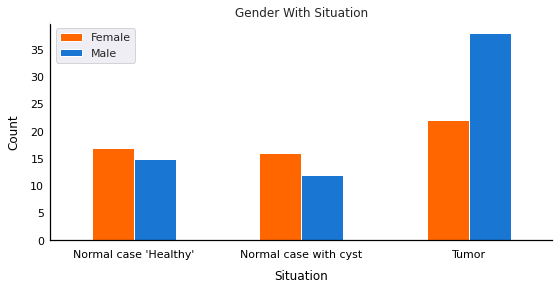

In [ ]:

fig, ax = plt.subplots(figsize = (9 , 4))
plt.xlabel('Number of Users')
plt.title('Gender With Situation')
z = means.plot.bar(ax=ax, capsize=6, rot=360 ,legend='upper', color=[ '#ff6600', '#1976D2'])
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000')  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
ax.tick_params(axis='y', pad=0)

ax.legend()

plt.legend(loc='upper left')
plt.xlabel("Situation", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.show()

2020    83
2021    37
Name: Date, dtype: int64

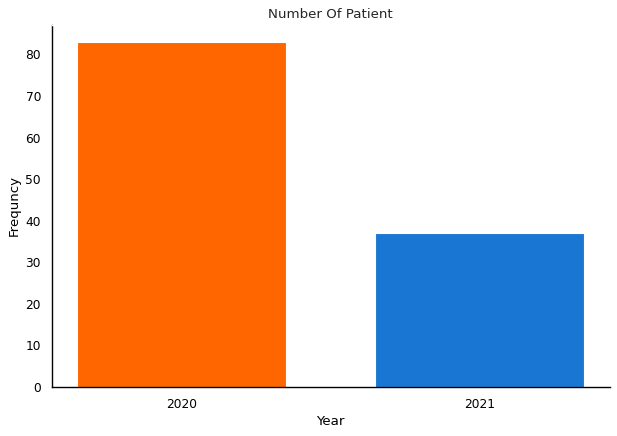

In [ ]:
labels = ['2020','2021']
Date_flg = patient_info['Date'].value_counts()
display(Date_flg)

fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , Date_flg ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Year')
plt.ylabel('Frequncy')
plt.title('Number Of Patient')
plt.show()

50-60    19
80+      16
60-70    14
40-50     6
30-40     5
Name: age_range, dtype: int64

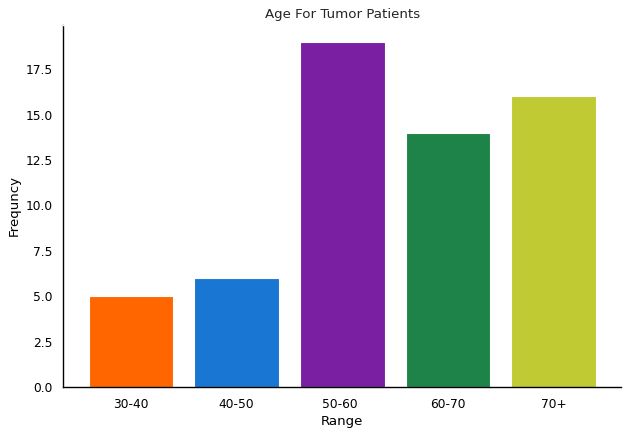

In [ ]:
age_range_flg =patient_info [patient_info['Tumor_label'] != 0 ]['age_range'].value_counts()
display(age_range_flg)
a_l = ['30-40','40-50','50-60 ','60-70','70+']
v_l = [5,6,19,14,16]
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar(a_l , v_l , color=['#ff6600', '#1976D2' , '#7B1FA2','#1D8348', '#C0CA33','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Range')
plt.ylabel('Frequncy')
plt.title('Age For Tumor Patients')
plt.show()

50-60    21
60-70    12
80+      11
40-50     9
30-40     3
Name: age_range, dtype: int64

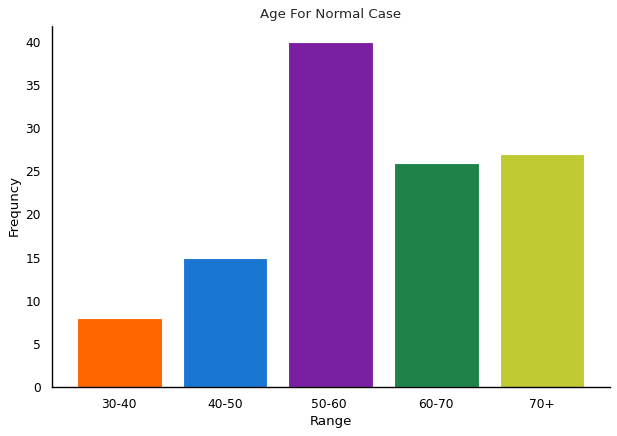

In [ ]:
age_range_flg =patient_info [patient_info['Tumor_label'] == 0 ]['age_range'].value_counts()
display(age_range_flg)
a_l = ['30-40','40-50','50-60 ','60-70','70+']
v_l = [8,15,40,26,27]
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar(a_l , v_l , color=['#ff6600', '#1976D2' , '#7B1FA2','#1D8348', '#C0CA33','#1f77b4', '#d62728', 'lightcoral','#7f7f7f'])
plt.xlabel('Range')
plt.ylabel('Frequncy')
plt.title('Age For Normal Case')
plt.show()
del age_range_flg

In [ ]:
patient_info [patient_info['Tumor_label'] != 'Uninfected' ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Patient_ID                       120 non-null    object  
 1   Patient_Num                      120 non-null    int64   
 2   Age                              120 non-null    int64   
 3   Gender                           120 non-null    object  
 4   Date                             120 non-null    int64   
 5   Taking_Contrast                  120 non-null    object  
 6   Clinical_data                    120 non-null    object  
 7   Symptoms                         120 non-null    object  
 8   Diagnosing_test                  120 non-null    object  
 9   Diagnosing_Right_Kidney          120 non-null    object  
 10  Injure_range_Right_K_in_Details  120 non-null    object  
 11  Segmentation_Right               120 non-null    object  
 12  Diagnosi

Female    33
Male      27
Name: Gender, dtype: int64

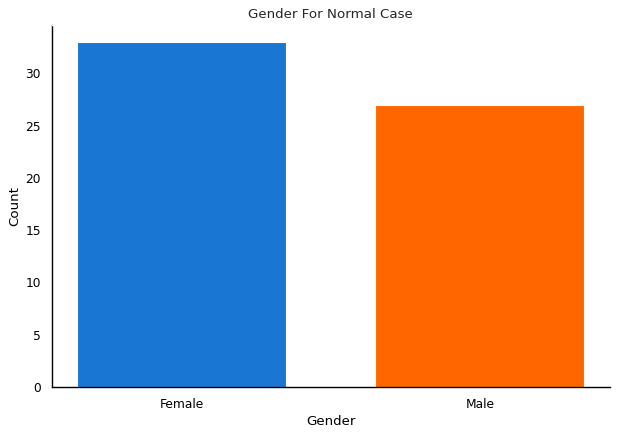

In [ ]:
Date_flg = patient_info[ patient_info['Tumor_label']== 0 ]['Gender'].value_counts()
display(Date_flg)
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( Date_flg.index , Date_flg ,width = 0.7,  color=['#1976D2' ,'#ff6600'] ,  align='center' , zorder=1)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender For Normal Case')
plt.show()

Male      38
Female    22
Name: Gender, dtype: int64

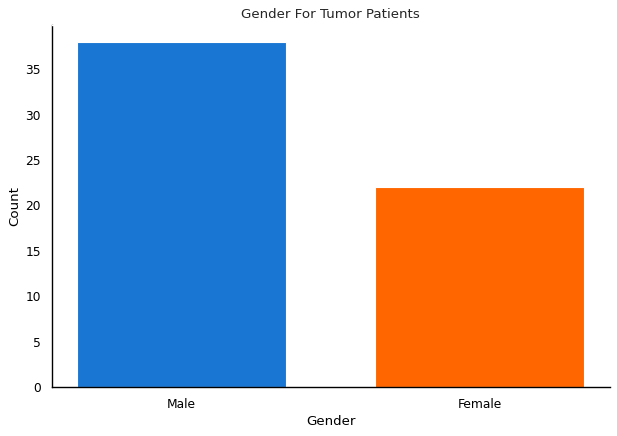

In [ ]:
Date_flg = patient_info [patient_info['Tumor_label'] != 0 ]['Gender'].value_counts()
display(Date_flg)
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( Date_flg.index , Date_flg ,width = 0.7,  color=[  '#1976D2' , '#ff6600',] ,  align='center' , zorder=1)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender For Tumor Patients')
plt.show()

Yes    35
No     25
Name: Taking_Contrast, dtype: int64

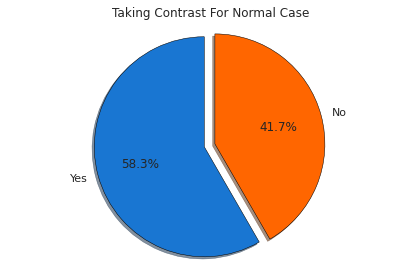

In [ ]:
# Pie chart
labels =patient_info [patient_info['Tumor_label'] == 0 ]['Taking_Contrast'].value_counts().index
sizes = patient_info [patient_info['Tumor_label'] == 0 ]['Taking_Contrast'].value_counts()
display(sizes) 
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = patient_info['Taking_Contrast'].value_counts() 
colors = ['#1976D2','#ff6600']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors ,
        shadow=True, startangle=90,
        wedgeprops= {"edgecolor":"black",
                     'linewidth': 0.5,
                     'antialiased': True} , explode = (0.1, 0) )

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Taking Contrast For Normal Case')
plt.tight_layout()
plt.show()

Yes    38
No     22
Name: Taking_Contrast, dtype: int64

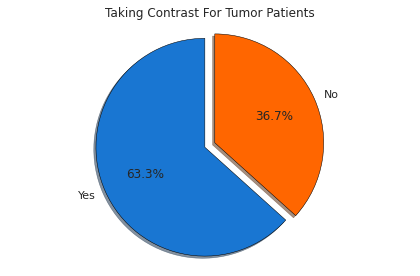

In [ ]:
# Pie chart
Taking_Contrast =  patient_info [patient_info['Tumor_label'] != 0 ]['Taking_Contrast'].value_counts()
labels =Taking_Contrast.index
sizes = Taking_Contrast
display(sizes) 
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = Taking_Contrast
colors = ['#1976D2', '#ff6600']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors ,
        shadow=True, startangle=90,
        wedgeprops= {"edgecolor":"black",
                     'linewidth': 0.5,
                     'antialiased': True} , explode = (0.1, 0) )

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Taking Contrast For Tumor Patients')
plt.tight_layout()
plt.show()

Adenoma           28
RCC               11
Secondary         11
Angiomyolipoma     9
Lipomas            1
Name: Tumor_Class, dtype: int64

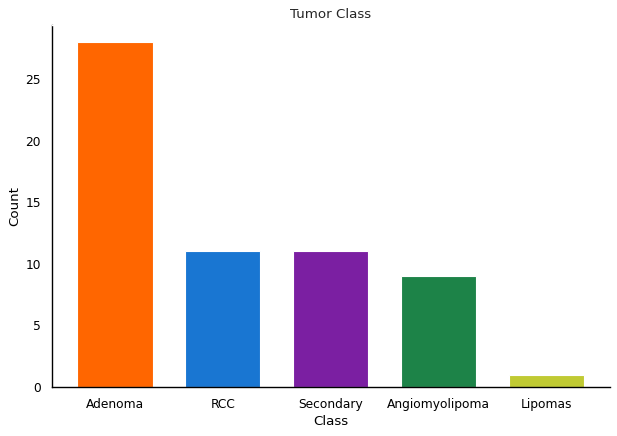

In [ ]:
Date_flg = patient_info['Tumor_Class'].value_counts()
del Date_flg['Uninfected']
display(Date_flg)
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
colors = ['#ff6600', '#1976D2' , '#7B1FA2','#1D8348', '#C0CA33','#1f77b4', '#d62728', 'lightcoral','#7f7f7f']
plt.bar( Date_flg.index , Date_flg ,width = 0.7,  color=colors , align='center' , zorder=1)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Tumor Class')
plt.show()

In [ ]:
Tumor_Class_with_gender_female= patient_info [patient_info['Gender']== "Female"]
Tumor_Class_with_gender_female = Tumor_Class_with_gender_female.groupby(['Tumor_Class']) 
Tumor_Class_with_gender_female = Tumor_Class_with_gender_female['Patient_Num'].describe()
Tumor_Class_with_gender_female = Tumor_Class_with_gender_female[['count']]
Tumor_Class_with_gender_female

,count
Tumor_Class,
Adenoma,9.0
Angiomyolipoma,7.0
RCC,1.0
Secondary,5.0
Uninfected,33.0


In [ ]:
Tumor_Class_with_gender_male= patient_info [patient_info['Gender']== "Male"]
Tumor_Class_with_gender_male = Tumor_Class_with_gender_male.groupby(['Tumor_Class']) 
Tumor_Class_with_gender_male = Tumor_Class_with_gender_male['Patient_Num'].describe()
Tumor_Class_with_gender_male

,count,mean,std,min,25%,50%,75%,max
Tumor_Class,,,,,,,,
Adenoma,19.0,12.842105,8.460780,1.0,5.50,11.0,19.50,28.0
Angiomyolipoma,2.0,31.500000,2.121320,30.0,30.75,31.5,32.25,33.0
Lipomas,1.0,38.000000,NaN,38.0,38.00,38.0,38.00,38.0
RCC,10.0,43.700000,3.335000,39.0,41.25,43.5,45.75,49.0
Secondary,6.0,55.833333,4.020779,50.0,53.00,57.0,58.75,60.0
Uninfected,27.0,93.740741,16.736861,63.0,81.50,97.0,108.50,117.0


In [ ]:
Situation_with_gender = patient_info['Situation'].value_counts()
means = pd.DataFrame()
means['Male']= Tumor_Class_with_gender_male['count']
means['Female'] = [9.0 , 7.0 , 0 , 1.0 , 5.0 , 33.0]

means['Tumor_Class']=Tumor_Class_with_gender_male.index
means = means.set_index('Tumor_Class')
means = means.drop(['Uninfected'])
display(means) 


,Male,Female
Tumor_Class,,
Adenoma,19.0,9.0
Angiomyolipoma,2.0,7.0
Lipomas,1.0,0.0
RCC,10.0,1.0
Secondary,6.0,5.0


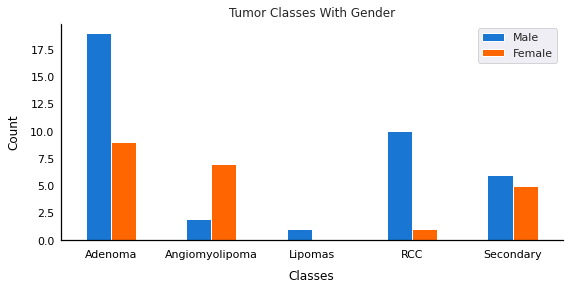

In [ ]:

fig, ax = plt.subplots(figsize = (9 , 4))
plt.xlabel('Number of Users')
plt.title('Tumor Classes With Gender')
colors = ['#ff6600', '#1976D2' , '#7B1FA2','#1D8348', '#C0CA33','#1f77b4', '#d62728', 'lightcoral','#7f7f7f']
z = means.plot.bar(ax=ax, capsize=6, rot=360 ,legend='upper', color=[  '#1976D2','#ff6600'])
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000')  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
ax.tick_params(axis='y', pad=0)
ax.legend()
plt.legend(loc='upper right')
plt.xlabel("Classes", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.show()

In [ ]:
Tumor_Class_with_gender_I= patient_info [patient_info['Stage']== "I"]
Tumor_Class_with_gender_I = patient_info.groupby(['Tumor_Class' , 'Stage'])
Tumor_Class_with_gender_I.describe()

Patient_Num                        ... Tumor_label          
                           count       mean        std  ...         50%  75%  max
Tumor_Class    Stage                                    ...                      
Adenoma        I            28.0  14.500000   8.225975  ...         1.0  1.0  1.0
Angiomyolipoma I             9.0  33.000000   2.738613  ...         1.0  1.0  1.0
Lipomas        I             1.0  38.000000        NaN  ...         1.0  1.0  1.0
RCC            I             8.0  43.250000   3.615443  ...         1.0  1.0  1.0
               II            1.0  47.000000        NaN  ...         1.0  1.0  1.0
               III           2.0  45.500000   0.707107  ...         1.0  1.0  1.0
Secondary      I             9.0  54.111111   2.934469  ...         1.0  1.0  1.0
               II            1.0  60.000000        NaN  ...         1.0  1.0  1.0
               IIII          1.0  58.000000        NaN  ...         1.0  1.0  1.0
Uninfected     Null         60.0  90.500000  17.464249  ...         0.0  0.0  0.0

[10 rows x 32 columns]

In [ ]:
Tumor_Class_with_gender_I= patient_info [patient_info['Stage']== "I"]
Tumor_Class_with_gender_I = Tumor_Class_with_gender_I.groupby(['Tumor_Class']) 
Tumor_Class_with_gender_I = Tumor_Class_with_gender_I['Patient_Num'].describe()
Tumor_Class_with_gender_I = Tumor_Class_with_gender_I[['count']]
Tumor_Class_with_gender_I

In [ ]:
Tumor_Class_with_gender_male= patient_info [patient_info['Gender']== "Male"]
Tumor_Class_with_gender_male = Tumor_Class_with_gender_male.groupby(['Tumor_Class']) 
Tumor_Class_with_gender_male = Tumor_Class_with_gender_male['Patient_Num'].describe()
Tumor_Class_with_gender_male

In [ ]:

fig, ax = plt.subplots(figsize = (9 , 4))
plt.xlabel('Number of Users')
plt.title('Tumor Classes With Gender')
colors = ['#ff6600', '#1976D2' , '#7B1FA2','#1D8348', '#C0CA33','#1f77b4', '#d62728', 'lightcoral','#7f7f7f']
z = means.plot.bar(ax=ax, capsize=6, rot=360 ,legend='upper', color=[  '#1976D2','#ff6600'])
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000')  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
ax.tick_params(axis='y', pad=0)
ax.legend()
plt.legend(loc='upper right')
plt.xlabel("Classes", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.show()

In [ ]:
Stage =  patient_info [patient_info['Tumor_label'] != 0 ]
Tumor_Class_with_gender_male= Stage [Stage['Gender']== "Male"]
Tumor_Class_with_gender_male = Tumor_Class_with_gender_male.groupby(['Stage']) 
Tumor_Class_with_gender_male = Tumor_Class_with_gender_male['Patient_Num'].describe()
Tumor_Class_with_gender_male

,count,mean,std,min,25%,50%,75%,max
Stage,,,,,,,,
I,34.0,26.705882,17.823256,1.0,10.25,24.0,41.75,59.0
II,1.0,60.000000,NaN,60.0,60.00,60.0,60.00,60.0
III,2.0,45.500000,0.707107,45.0,45.25,45.5,45.75,46.0
IIII,1.0,58.000000,NaN,58.0,58.00,58.0,58.00,58.0


In [ ]:
Tumor_Class_with_gender_female= Stage [Stage['Gender']== "Female"]
Tumor_Class_with_gender_female = Tumor_Class_with_gender_female.groupby(['Stage']) 
Tumor_Class_with_gender_female = Tumor_Class_with_gender_female['Patient_Num'].describe()
Tumor_Class_with_gender_female

,count,mean,std,min,25%,50%,75%,max
Stage,,,,,,,,
I,21.0,31.714286,15.235297,7.0,21.0,31.0,37.0,57.0
II,1.0,47.000000,NaN,47.0,47.0,47.0,47.0,47.0


In [ ]:
means = pd.DataFrame()
means['Male']= Tumor_Class_with_gender_male['count']
means['Female'] = [21.0 , 1.0 , 0 , 0 ]

means['Tumor_Class']=Tumor_Class_with_gender_male.index
means = means.set_index('Tumor_Class')
display(means) 


,Male,Female
Tumor_Class,,
I,34.0,21.0
II,1.0,1.0
III,2.0,0.0
IIII,1.0,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Unrecognized location 'upper'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


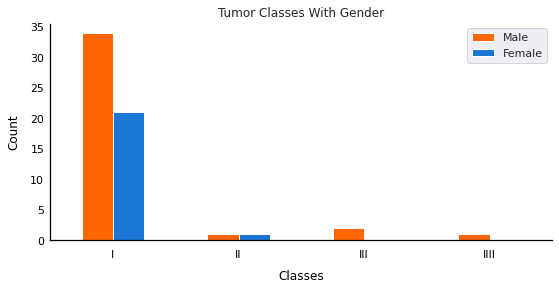

In [ ]:

fig, ax = plt.subplots(figsize = (9 , 4))
plt.xlabel('Number of Users')
plt.title('Tumor Classes With Gender')
colors = ['#ff6600', '#1976D2' , '#7B1FA2','#1D8348', '#C0CA33','#1f77b4', '#d62728', 'lightcoral','#7f7f7f']

z = means.plot.bar(ax=ax, capsize=6, rot=360 ,legend='upper', color=[ '#ff6600', '#1976D2'])
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000')  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')

ax.tick_params(axis='y', pad=0)

ax.legend()

plt.legend(loc='upper')
plt.xlabel("Classes", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.show()

I       55
III      2
II       2
IIII     1
Name: Stage, dtype: int64

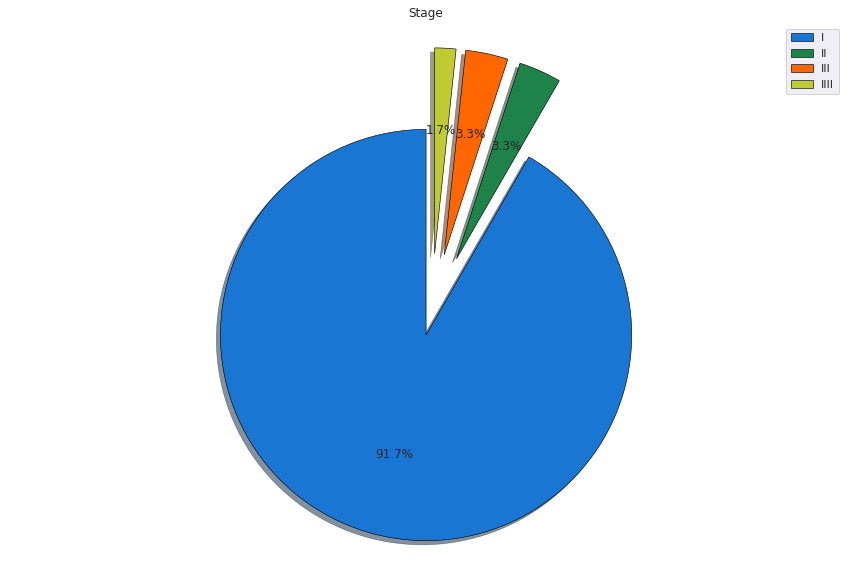

In [ ]:
Stage_flg = patient_info[patient_info['Stage']!='Null']
Stage_flg = Stage_flg['Stage'].value_counts()
display(Stage_flg)
fig = plt.figure(figsize =(15, 10))
colors = [  '#1976D2' ,'#1D8348' ,'#ff6600', '#C0CA33',]
labels = [r'I', r'II', r'III' ,  r'IIII']
plt.pie([55,2 , 2, 1], autopct='%1.1f%%',colors=colors ,
        shadow=True, startangle=90,
        wedgeprops= {"edgecolor":"black",
                     'linewidth': 0.6,
                     'antialiased': True} , explode = (0.1, 0.3,0.3,0.3) )

plt.legend( labels, loc="best")
plt.axis('equal')
plt.title('Stage')
plt.show()
del Stage_flg